In [1]:
import pandas as pd
import numpy as np

In [2]:
data_dir = '../data/train_test'
selected_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

## Data preprocessing

### Augmenting rows

In [63]:
def add_column_statistics(df, columns, by_column=None, add_std=False):
    df = df.copy()

    if by_column:
        for i in columns:
            df[f'{i}_min_by_fid'] = df.groupby(by_column)[i].transform('min')
            df[f'{i}_max_by_fid'] = df.groupby(by_column)[i].transform('max')
            df[f'{i}_avg_by_fid'] = df.groupby(by_column)[i].transform('mean')

            if add_std:
                df[f'{i}_std_by_fid'] = df.groupby(by_column)[i].transform('std')
    else:
        for i in columns:
            if add_std:
                df[f'{i}_std'] = df.filter(regex = f'^{i}').std(axis = 1)
                
            df[f'{i}_max'] = df.filter(regex = f'^{i}').max(axis = 1)
            df[f'{i}_min'] = df.filter(regex = f'^{i}').min(axis = 1)
            df[f'{i}_avg'] =df.filter(regex = f'^{i}').mean(axis = 1)

    return df
    

def add_column_mappings(df, columns, add_sqrt=False):
    df = df.copy()

    for i in columns:
        
        if add_sqrt:
            df[f'{i}_sqrt'] = np.sqrt(df[i].values)
            
        df[f'{i}_exp'] = np.exp(df[i].values)
        df[f'{i}_^2'] = df[i].values**2
    
    return df

### Add spetral indices

In [77]:
spectral_indices = [
    "NDVI",
    "GNDVI",
    # "EVI",
    "EVI2",
    # "AdvVI", # Advanced vegitation index
    "BSI",
    "SI",
    "NDWI",
    "NDMI",
    "NPCRI",
    "SAVI",
    "MSI",
    "GCI",
    "NBRI",
    "NDSI",
    "NDGI",
    "ARVI",
    "SIPI",
    
    # other from paper  https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-12/issue-02/026019/Crop-classification-from-Sentinel-2-derived-vegetation-indices-using-ensemble/10.1117/1.JRS.12.026019.full 
    "AFRI1.6",
    "AFRI2.1",
    "ARI",
    # "ARVI_paper",
    "ARVI2", # depends on a hyperparameter
    # "ATSAVI" # depends on a hyperparameter
    "AshVI", # Ashburn vegetation index
    "BNDVI",
    "BRI",
    
    "BWDRVI",
    "MCARI1",
    "MCARI2",
    "CCCI",
    "CRI550",
    "CRI700",
    "CVI",
    "Datt1",
    "Datt2",
    "Datt3",
    "DVI"
]

def add_spectral_indices(df, phi=1, a=1.22, b=0.03, X=0.08):
    df = df.copy()
    
    df["NDVI"] = (df["B08"] - df["B04"]) / (df["B08"] + df["B04"])
    df["GNDVI"] = (df["B08"] - df["B03"]) / (df["B08"] + df["B03"])
    # df["EVI"] = 2.5 * ((df["B08"] - df["B04"]) / ((df["B08"] + 6.0 * df["B04"] - 7.5 * df['B02']) + 1.0))
    df["EVI2"] = 2.4 * (df["B08"] - df["B04"]) / (df["B08"] + df["B04"] + 1.0)
    # df["AdvVI"] = (df["B08"] * (1 - df["B04"]) * (df["B08"] - df["B04"]))**(1/3)
    df["BSI"] = ((df["B11"] + df["B04"]) - (df["B08"] + df["B02"])) / ((df["B11"] + df["B04"]) + (df["B08"] + df["B02"]))
    df["SI"] = ((1 - df["B02"]) * (1 - df["B03"]) * (1 - df["B04"]))
    df["NDWI"] = (df["B03"] - df["B08"]) / (df["B03"] + df["B08"])
    df["NDMI"] = (df["B08"] - df["B11"]) / (df["B08"] + df["B11"]) 
    df["NPCRI"] = (df["B04"] - df["B02"]) / (df["B04"] + df["B02"]) 
    df["SAVI"] = (df["B08"] - df["B04"]) / (df["B08"] + df["B04"] + 0.428) * (1.428)
    df["MSI"] = df["B11"] / df["B08"]
    df["GCI"] = (df["B09"] / df["B03"]) - 1
    df["NBRI"] = (df["B08"] - df["B12"]) / (df["B08"] + df["B12"])
    df["NDSI"] = (df["B03"] - df["B11"]) / (df["B03"] + df["B11"])
    df["NDGI"] = (df["B03"] - df["B04"]) / (df["B03"] + df["B04"]) 
    df["ARVI"] = (df["B08"] - (2 * df["B04"]) + df["B02"]) / (df["B08"] + (2 * df["B04"]) + df["B02"]) 
    df["SIPI"] = (df["B08"] - df["B02"]) / (df["B08"] - df["B04"])
    
    # other from paper  https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-12/issue-02/026019/Crop-classification-from-Sentinel-2-derived-vegetation-indices-using-ensemble/10.1117/1.JRS.12.026019.full 
    df["AFRI1.6"] = (df["B8A"] - 0.66*df["B11"]) / (df["B8A"] + 0.66*df["B11"])
    df["AFRI2.1"] = (df["B8A"] - 0.5*df["B12"]) / (df["B8A"] + 0.5*df["B12"])
    df["ARI"] = ((1/df["B03"]) - (1/df["B05"]))
    # df["ARVI_paper"] = (df["B08"] - (df["B04"] - phi*(df["B02"] - df["B04"]))) / (df["B08"] + (df["B04"] - phi*(df["B02"] - df["B04"])))
    df["ARVI2"] = -0.18 + 1.17 + ((df["B08"] - df["B04"]) / (df["B08"] + df["B04"]))
    # df["ATSAVI"] = a*(df["B08"] - a*df["B04"] - b) / (df["B08"] + df["B04"] - a*b + X*(1 + a**2))
    df["AshVI"] = 2*df["B8A"] - df["04"]
    df["BNDVI"] = (df["B08"] - df["B02"]) / (df["B08"] + df["B02"])
    df["BRI"] = ((1 / df["B03"]) - (1 / df["B05"])) / df["B06"]
    
    df["BWDRVI"] = (0.1*df["B07"] - df["B02"])/(0.1*df["B07"] + df["B02"])
    
    # Chlorophyll absorption ratio index
    df["MCARI1"] = 1.2 * (2.5 * df["B08"] - df["B04"]) - 1.3*(df["B08"] - df["B03"])
    df["MCARI2"] = 1.5 * ((2.5 * (df["B08"] - df["B04"]) - 1.3*(df["B08"] - df["B03"])) / ((((2*df["B08"] + 1)**2 - (6*df["B08"] - 5*(df["B04"]**(1/2)))) ** (1/2))) - 0.5)
    
    df["CCCI"] = ((df["B08"] - df["B05"]) / (df["B08"] + df["B05"])) / ((df["B08"] - df["B04"]) / (df["B08"] + df["B04"]))
    df["CRI550"] = (1 / df["B02"]) - (1 / df["B03"])
    df["CRI700"] = (1 / df["B02"]) - (1 / df["B05"])
    df["CVI"] = (df["B08"] * df["B08"]) / (df["B03"])**2
    df["Datt1"] = (df["B08"] - df["B05"]) / (df["B08"] + df["B04"])
    df["Datt2"] = df["B04"] / (df["B03"] * df["B05"])
    df["Datt3"] = df["B04"] / (df["B03"] * df["B05"])
    df["DVI"] = 
    
    return df

In [78]:
df_train = pd.read_csv(f"{data_dir}/preprocessed/tabular_train.csv")
df_test = pd.read_csv(f"{data_dir}/preprocessed/tabular_test.csv")
df_all = pd.concat([df_train, df_test])

display(df_all.head())

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,crop
0,44,40,40,42,45,59,70,63,76,13,78,55,1374,1.0
1,44,40,40,42,45,59,70,62,76,13,78,55,1374,1.0
2,44,40,39,42,46,52,58,54,62,16,72,53,3293,1.0
3,44,41,39,43,48,58,65,61,71,16,78,61,3293,1.0
4,44,40,40,44,48,58,65,64,71,16,78,61,3293,1.0


In [79]:
# spectral bands
df_all = add_column_statistics(df_all, selected_bands)
df_all = add_column_mappings(df_all, selected_bands, add_sqrt=True)
df_all = add_column_statistics(df_all, selected_bands, "field_id")

# spectral indices
df_all = add_spectral_indices(df_all)
df_all = add_column_statistics(df_all, spectral_indices)
df_all = add_column_mappings(df_all, spectral_indices)
df_all = add_column_statistics(df_all, spectral_indices, "field_id")

display(df_all.head())

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,AFRI1.6_avg_by_fid,AFRI2.1_min_by_fid,AFRI2.1_max_by_fid,AFRI2.1_avg_by_fid,ARI_min_by_fid,ARI_max_by_fid,ARI_avg_by_fid,ATSAVI_min_by_fid,ATSAVI_max_by_fid,ATSAVI_avg_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,0.185581,0.438424,0.504950,0.454322,0.001744,0.003723,0.002933,0.086935,0.210294,0.121074
1,44,40,40,42,45,59,70,62,76,13,...,0.185581,0.438424,0.504950,0.454322,0.001744,0.003723,0.002933,0.086935,0.210294,0.121074
2,44,40,39,42,46,52,58,54,62,16,...,0.163583,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715
3,44,41,39,43,48,58,65,61,71,16,...,0.163583,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715
4,44,40,40,44,48,58,65,64,71,16,...,0.163583,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715


In [80]:
df_all = df_all.join(df_all.groupby("field_id").size().rename(f'num_pixels_by_fid'), on='field_id')

df_all.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,AFRI2.1_min_by_fid,AFRI2.1_max_by_fid,AFRI2.1_avg_by_fid,ARI_min_by_fid,ARI_max_by_fid,ARI_avg_by_fid,ATSAVI_min_by_fid,ATSAVI_max_by_fid,ATSAVI_avg_by_fid,num_pixels_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,0.438424,0.504950,0.454322,0.001744,0.003723,0.002933,0.086935,0.210294,0.121074,36
1,44,40,40,42,45,59,70,62,76,13,...,0.438424,0.504950,0.454322,0.001744,0.003723,0.002933,0.086935,0.210294,0.121074,36
2,44,40,39,42,46,52,58,54,62,16,...,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715,19
3,44,41,39,43,48,58,65,61,71,16,...,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715,19
4,44,40,40,44,48,58,65,64,71,16,...,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715,19


In [81]:
tmp = df_all.drop(columns=["crop"])

tmp.loc[:, tmp.isna().any()]

""
0
1
2
3
4
...
49313
49314
49315
49316


## Feature selection

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
df_all = df_all.reset_index(drop=True)
df_all.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,AFRI2.1_min_by_fid,AFRI2.1_max_by_fid,AFRI2.1_avg_by_fid,ARI_min_by_fid,ARI_max_by_fid,ARI_avg_by_fid,ATSAVI_min_by_fid,ATSAVI_max_by_fid,ATSAVI_avg_by_fid,num_pixels_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,0.438424,0.504950,0.454322,0.001744,0.003723,0.002933,0.086935,0.210294,0.121074,36
1,44,40,40,42,45,59,70,62,76,13,...,0.438424,0.504950,0.454322,0.001744,0.003723,0.002933,0.086935,0.210294,0.121074,36
2,44,40,39,42,46,52,58,54,62,16,...,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715,19
3,44,41,39,43,48,58,65,61,71,16,...,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715,19
4,44,40,40,44,48,58,65,64,71,16,...,0.399015,0.452632,0.418374,0.002848,0.005288,0.003998,0.034635,0.175459,0.094715,19


In [84]:
X_train = df_all[~df_all["crop"].isnull()]
df_test = df_all[df_all["crop"].isnull()]
y_train = X_train["crop"]

X_train = X_train.drop(columns=["field_id", "crop"])
X_test = df_test.drop(columns=["field_id", "crop"])

In [85]:
X_train.shape, y_train.shape, X_test.shape

((188228, 302), (188228,), (49318, 302))

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 5, shuffle = True)

In [87]:
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_class_weight

In [88]:
label_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

In [89]:
# cb_pi --> catboost_permutation_importance\n",
cb_pi = CatBoostClassifier(n_estimators = 1400, learning_rate = 0.03, random_state = 11, task_type = "GPU")
cb_pi.fit(X_train, y_train)

0:	learn: 2.4152623	total: 48.3ms	remaining: 1m 7s
1:	learn: 2.2961460	total: 98.4ms	remaining: 1m 8s
2:	learn: 2.1988200	total: 148ms	remaining: 1m 8s
3:	learn: 2.1152016	total: 195ms	remaining: 1m 8s
4:	learn: 2.0433680	total: 248ms	remaining: 1m 9s
5:	learn: 1.9789502	total: 295ms	remaining: 1m 8s
6:	learn: 1.9210507	total: 340ms	remaining: 1m 7s
7:	learn: 1.8687009	total: 381ms	remaining: 1m 6s
8:	learn: 1.8209468	total: 426ms	remaining: 1m 5s
9:	learn: 1.7776656	total: 468ms	remaining: 1m 5s
10:	learn: 1.7376110	total: 511ms	remaining: 1m 4s
11:	learn: 1.7011219	total: 557ms	remaining: 1m 4s
12:	learn: 1.6668521	total: 608ms	remaining: 1m 4s
13:	learn: 1.6336874	total: 649ms	remaining: 1m 4s
14:	learn: 1.6035490	total: 698ms	remaining: 1m 4s
15:	learn: 1.5744274	total: 739ms	remaining: 1m 3s
16:	learn: 1.5474800	total: 782ms	remaining: 1m 3s
17:	learn: 1.5225354	total: 824ms	remaining: 1m 3s
18:	learn: 1.4982894	total: 868ms	remaining: 1m 3s
19:	learn: 1.4752314	total: 913ms	remai

In [90]:
import eli5
from eli5.sklearn import PermutationImportance

In [91]:
pi = PermutationImportance(cb_pi, random_state = 90, n_iter = 5)
pi.fit(X_val, y_val)
eli5.show_weights(pi, feature_names = X_train.columns.tolist(), top = None)

Weight,Feature
0.0467 ± 0.0016,num_pixels_by_fid
0.0362 ± 0.0012,NDSI_min_by_fid
0.0260 ± 0.0010,NDGI_min_by_fid
0.0172 ± 0.0009,ARI_avg_by_fid
0.0155 ± 0.0008,NDGI_avg_by_fid
0.0117 ± 0.0009,B12_max_by_fid
0.0097 ± 0.0008,NDSI_avg_by_fid
0.0083 ± 0.0008,NBRI_min_by_fid
0.0074 ± 0.0008,GCI_avg_by_fid
0.0073 ± 0.0009,B08_max_by_fid


In [92]:
pi_results = eli5.formatters.as_dataframe.explain_weights_df(pi, feature_names = X_train.columns.tolist())
# feature importance weigth threshold is 0\n",
low_importance = pi_results[pi_results.weight <= 0].feature.values
low_importance

array(['SI_^2', 'B07_sqrt', 'B8A_^2', 'B8A_exp', 'B8A_sqrt', 'B08_^2',
       'B08_exp', 'B08_sqrt', 'B07_^2', 'B07_exp', 'B06_exp', 'B06_^2',
       'B09_^2', 'B06_sqrt', 'B05_^2', 'B05_exp', 'B05_sqrt', 'B04_^2',
       'B04_exp', 'B04_sqrt', 'B03_^2', 'B09_sqrt', 'B11_sqrt',
       'B03_sqrt', 'AFRI1.6_exp', 'GCI_^2', 'NBRI_exp', 'NBRI_^2',
       'SI_exp', 'NDSI_^2', 'NDGI_exp', 'ARVI_exp', 'ARVI_^2', 'SIPI_exp',
       'AFRI1.6_^2', 'B11_exp', 'AFRI2.1_exp', 'AFRI2.1_^2', 'ARI_exp',
       'ATSAVI_exp', 'ATSAVI_^2', 'B12_^2', 'B12_exp', 'B12_sqrt',
       'B11_^2', 'B03_exp', 'B02_^2', 'MSI_^2', 'B02_exp', 'B05_min',
       'B05_max', 'B04_avg', 'B04_min', 'B04_max', 'B03_avg', 'B03_min',
       'B03_max', 'B02_avg', 'B02_min', 'B02_max', 'B12', 'B11', 'B09',
       'B8A', 'B08', 'B07', 'B06', 'B05', 'B03', 'B02', 'B05_avg',
       'B06_max', 'B06_min', 'B09_min', 'B02_sqrt', 'B01_^2', 'B12_avg',
       'B12_min', 'B12_max', 'B11_avg', 'B11_min', 'B11_max', 'B09_avg',
       'B09_

In [93]:
features_to_drop = low_importance

In [94]:
X_train_curated = X_train.drop(columns = features_to_drop)
X_test_curated = X_test.drop(columns = features_to_drop)

X_train_curated.shape, X_test_curated.shape

((150582, 95), (49318, 95))

## Cross Validation

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

cb = CatBoostClassifier(n_estimators = 1500, learning_rate=0.03, depth = 6, random_state = 11, bagging_temperature = 1, task_type = "GPU")

# Use "class_weights = label_weights" for cross validation
cb2 = CatBoostClassifier(n_estimators = 1100, learning_rate=0.03, depth = 6, random_state = 11, bagging_temperature = 1, task_type = "GPU", class_weights = label_weights)

lda = LinearDiscriminantAnalysis()
bc = BaggingClassifier(base_estimator = lda, n_estimators = 30, random_state = 0)
      

In [40]:
# Catboost without weights
cv1 = cross_val_predict(cb, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.4168628	total: 20.2ms	remaining: 30.3s
1:	learn: 2.3012766	total: 40.5ms	remaining: 30.4s
2:	learn: 2.2026997	total: 61ms	remaining: 30.4s
3:	learn: 2.1189348	total: 80.5ms	remaining: 30.1s
4:	learn: 2.0457105	total: 99.6ms	remaining: 29.8s
5:	learn: 1.9803801	total: 119ms	remaining: 29.6s
6:	learn: 1.9219707	total: 139ms	remaining: 29.6s
7:	learn: 1.8695086	total: 158ms	remaining: 29.5s
8:	learn: 1.8221238	total: 176ms	remaining: 29.2s
9:	learn: 1.7779495	total: 194ms	remaining: 28.9s
10:	learn: 1.7374268	total: 212ms	remaining: 28.7s
11:	learn: 1.6999888	total: 230ms	remaining: 28.5s
12:	learn: 1.6642287	total: 249ms	remaining: 28.4s
13:	learn: 1.6322653	total: 265ms	remaining: 28.2s
14:	learn: 1.6018574	total: 283ms	remaining: 28s
15:	learn: 1.5727558	total: 301ms	remaining: 27.9s
16:	learn: 1.5460633	total: 320ms	remaining: 27.9s
17:	learn: 1.5205333	total: 337ms	remaining: 27.8s
18:	learn: 1.4961064	total: 356ms	remaining: 27.7s
19:	learn: 1.4734683	total: 373ms	remain

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s


0:	learn: 2.4166470	total: 16.7ms	remaining: 25.1s
1:	learn: 2.3010721	total: 34.6ms	remaining: 25.9s
2:	learn: 2.2028338	total: 51.7ms	remaining: 25.8s
3:	learn: 2.1193978	total: 67.4ms	remaining: 25.2s
4:	learn: 2.0457231	total: 85ms	remaining: 25.4s
5:	learn: 1.9812212	total: 101ms	remaining: 25.2s
6:	learn: 1.9230255	total: 119ms	remaining: 25.4s
7:	learn: 1.8698936	total: 135ms	remaining: 25.2s
8:	learn: 1.8228355	total: 154ms	remaining: 25.5s
9:	learn: 1.7781014	total: 171ms	remaining: 25.5s
10:	learn: 1.7363660	total: 189ms	remaining: 25.5s
11:	learn: 1.6996558	total: 205ms	remaining: 25.4s
12:	learn: 1.6637667	total: 224ms	remaining: 25.6s
13:	learn: 1.6307167	total: 240ms	remaining: 25.5s
14:	learn: 1.6002450	total: 259ms	remaining: 25.6s
15:	learn: 1.5715443	total: 276ms	remaining: 25.6s
16:	learn: 1.5448927	total: 293ms	remaining: 25.5s
17:	learn: 1.5190009	total: 310ms	remaining: 25.6s
18:	learn: 1.4954070	total: 327ms	remaining: 25.5s
19:	learn: 1.4723867	total: 344ms	rema

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.4s remaining:    0.0s


0:	learn: 2.4165994	total: 16.8ms	remaining: 25.3s
1:	learn: 2.2993516	total: 34.2ms	remaining: 25.6s
2:	learn: 2.2010575	total: 51.2ms	remaining: 25.6s
3:	learn: 2.1168372	total: 66.8ms	remaining: 25s
4:	learn: 2.0440074	total: 82.6ms	remaining: 24.7s
5:	learn: 1.9791269	total: 99ms	remaining: 24.7s
6:	learn: 1.9204743	total: 116ms	remaining: 24.8s
7:	learn: 1.8678166	total: 133ms	remaining: 24.8s
8:	learn: 1.8210207	total: 150ms	remaining: 24.9s
9:	learn: 1.7774114	total: 167ms	remaining: 24.9s
10:	learn: 1.7369585	total: 183ms	remaining: 24.8s
11:	learn: 1.6999542	total: 200ms	remaining: 24.9s
12:	learn: 1.6644170	total: 218ms	remaining: 24.9s
13:	learn: 1.6324952	total: 233ms	remaining: 24.7s
14:	learn: 1.6018148	total: 250ms	remaining: 24.7s
15:	learn: 1.5728716	total: 267ms	remaining: 24.8s
16:	learn: 1.5462956	total: 284ms	remaining: 24.8s
17:	learn: 1.5206077	total: 301ms	remaining: 24.8s
18:	learn: 1.4959309	total: 318ms	remaining: 24.8s
19:	learn: 1.4733335	total: 335ms	remai

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


0:	learn: 2.4190319	total: 17.7ms	remaining: 26.6s
1:	learn: 2.3045678	total: 35.7ms	remaining: 26.7s
2:	learn: 2.2046848	total: 52.4ms	remaining: 26.1s
3:	learn: 2.1191069	total: 68.8ms	remaining: 25.7s
4:	learn: 2.0471593	total: 85.8ms	remaining: 25.6s
5:	learn: 1.9820541	total: 102ms	remaining: 25.5s
6:	learn: 1.9234628	total: 119ms	remaining: 25.3s
7:	learn: 1.8702915	total: 135ms	remaining: 25.2s
8:	learn: 1.8238261	total: 153ms	remaining: 25.3s
9:	learn: 1.7796628	total: 170ms	remaining: 25.3s
10:	learn: 1.7383481	total: 187ms	remaining: 25.4s
11:	learn: 1.6998642	total: 205ms	remaining: 25.4s
12:	learn: 1.6648812	total: 222ms	remaining: 25.4s
13:	learn: 1.6329622	total: 237ms	remaining: 25.2s
14:	learn: 1.6027202	total: 253ms	remaining: 25.1s
15:	learn: 1.5737725	total: 270ms	remaining: 25.1s
16:	learn: 1.5460751	total: 288ms	remaining: 25.1s
17:	learn: 1.5202926	total: 305ms	remaining: 25.1s
18:	learn: 1.4959781	total: 322ms	remaining: 25.1s
19:	learn: 1.4729047	total: 339ms	re

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


0:	learn: 2.4165981	total: 17.4ms	remaining: 26.1s
1:	learn: 2.3006481	total: 34.7ms	remaining: 26s
2:	learn: 2.2020407	total: 52.2ms	remaining: 26s
3:	learn: 2.1184812	total: 68.8ms	remaining: 25.7s
4:	learn: 2.0463308	total: 87.2ms	remaining: 26.1s
5:	learn: 1.9815482	total: 105ms	remaining: 26.1s
6:	learn: 1.9230893	total: 122ms	remaining: 26s
7:	learn: 1.8701830	total: 138ms	remaining: 25.8s
8:	learn: 1.8236437	total: 155ms	remaining: 25.7s
9:	learn: 1.7796066	total: 172ms	remaining: 25.6s
10:	learn: 1.7383431	total: 189ms	remaining: 25.6s
11:	learn: 1.7007309	total: 205ms	remaining: 25.4s
12:	learn: 1.6654427	total: 221ms	remaining: 25.3s
13:	learn: 1.6321903	total: 238ms	remaining: 25.3s
14:	learn: 1.6019438	total: 254ms	remaining: 25.1s
15:	learn: 1.5729945	total: 270ms	remaining: 25s
16:	learn: 1.5462214	total: 286ms	remaining: 25s
17:	learn: 1.5207492	total: 303ms	remaining: 25s
18:	learn: 1.4970064	total: 319ms	remaining: 24.9s
19:	learn: 1.4738871	total: 337ms	remaining: 24.

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [41]:
# Catboost with weights
cv2 = cross_val_predict(cb2, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.4694664	total: 18.5ms	remaining: 20.3s
1:	learn: 2.3888081	total: 37.8ms	remaining: 20.8s
2:	learn: 2.3225596	total: 56.8ms	remaining: 20.8s
3:	learn: 2.2523453	total: 76.6ms	remaining: 21s
4:	learn: 2.1999509	total: 94.9ms	remaining: 20.8s
5:	learn: 2.1506811	total: 113ms	remaining: 20.6s
6:	learn: 2.1065734	total: 131ms	remaining: 20.4s
7:	learn: 2.0515116	total: 151ms	remaining: 20.6s
8:	learn: 2.0054656	total: 169ms	remaining: 20.5s
9:	learn: 1.9609348	total: 189ms	remaining: 20.6s
10:	learn: 1.9203926	total: 207ms	remaining: 20.5s
11:	learn: 1.8866909	total: 224ms	remaining: 20.3s
12:	learn: 1.8497007	total: 242ms	remaining: 20.2s
13:	learn: 1.8219234	total: 258ms	remaining: 20s
14:	learn: 1.7926054	total: 274ms	remaining: 19.8s
15:	learn: 1.7647020	total: 291ms	remaining: 19.7s
16:	learn: 1.7331731	total: 310ms	remaining: 19.8s
17:	learn: 1.7109300	total: 327ms	remaining: 19.7s
18:	learn: 1.6866492	total: 345ms	remaining: 19.6s
19:	learn: 1.6624471	total: 364ms	remain

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.4s remaining:    0.0s


0:	learn: 2.4743208	total: 19ms	remaining: 20.9s
1:	learn: 2.4018187	total: 37.3ms	remaining: 20.5s
2:	learn: 2.3362590	total: 55.1ms	remaining: 20.2s
3:	learn: 2.2630254	total: 74.7ms	remaining: 20.5s
4:	learn: 2.2117189	total: 92.6ms	remaining: 20.3s
5:	learn: 2.1619346	total: 111ms	remaining: 20.2s
6:	learn: 2.1159021	total: 129ms	remaining: 20.1s
7:	learn: 2.0644533	total: 148ms	remaining: 20.3s
8:	learn: 2.0231442	total: 167ms	remaining: 20.2s
9:	learn: 1.9817863	total: 186ms	remaining: 20.2s
10:	learn: 1.9390022	total: 204ms	remaining: 20.2s
11:	learn: 1.9078631	total: 221ms	remaining: 20s
12:	learn: 1.8692458	total: 241ms	remaining: 20.1s
13:	learn: 1.8318388	total: 260ms	remaining: 20.1s
14:	learn: 1.7997651	total: 278ms	remaining: 20.1s
15:	learn: 1.7718247	total: 295ms	remaining: 20s
16:	learn: 1.7394379	total: 313ms	remaining: 19.9s
17:	learn: 1.7163052	total: 330ms	remaining: 19.8s
18:	learn: 1.6964307	total: 346ms	remaining: 19.7s
19:	learn: 1.6714910	total: 363ms	remainin

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.4s remaining:    0.0s


0:	learn: 2.4730208	total: 19.6ms	remaining: 21.6s
1:	learn: 2.3924789	total: 38.4ms	remaining: 21.1s
2:	learn: 2.3267062	total: 57.5ms	remaining: 21s
3:	learn: 2.2695026	total: 76ms	remaining: 20.8s
4:	learn: 2.2177590	total: 94.4ms	remaining: 20.7s
5:	learn: 2.1657788	total: 113ms	remaining: 20.6s
6:	learn: 2.1132049	total: 133ms	remaining: 20.8s
7:	learn: 2.0605500	total: 153ms	remaining: 20.9s
8:	learn: 2.0214682	total: 171ms	remaining: 20.7s
9:	learn: 1.9767662	total: 191ms	remaining: 20.8s
10:	learn: 1.9333249	total: 212ms	remaining: 21s
11:	learn: 1.9034048	total: 230ms	remaining: 20.8s
12:	learn: 1.8626699	total: 249ms	remaining: 20.9s
13:	learn: 1.8252285	total: 269ms	remaining: 20.8s
14:	learn: 1.7964855	total: 286ms	remaining: 20.7s
15:	learn: 1.7687748	total: 303ms	remaining: 20.5s
16:	learn: 1.7372145	total: 322ms	remaining: 20.5s
17:	learn: 1.7153485	total: 340ms	remaining: 20.4s
18:	learn: 1.6956743	total: 356ms	remaining: 20.3s
19:	learn: 1.6684474	total: 374ms	remainin

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.4s remaining:    0.0s


0:	learn: 2.4726140	total: 19.1ms	remaining: 21s
1:	learn: 2.3896801	total: 38.3ms	remaining: 21s
2:	learn: 2.3235934	total: 56.1ms	remaining: 20.5s
3:	learn: 2.2619532	total: 74ms	remaining: 20.3s
4:	learn: 2.2104451	total: 91.7ms	remaining: 20.1s
5:	learn: 2.1601372	total: 109ms	remaining: 19.9s
6:	learn: 2.1026649	total: 128ms	remaining: 20.1s
7:	learn: 2.0512868	total: 148ms	remaining: 20.2s
8:	learn: 2.0126949	total: 165ms	remaining: 20s
9:	learn: 1.9665162	total: 185ms	remaining: 20.1s
10:	learn: 1.9246290	total: 204ms	remaining: 20.2s
11:	learn: 1.8934598	total: 220ms	remaining: 20s
12:	learn: 1.8552944	total: 239ms	remaining: 20s
13:	learn: 1.8264094	total: 257ms	remaining: 19.9s
14:	learn: 1.7949135	total: 275ms	remaining: 19.9s
15:	learn: 1.7664162	total: 293ms	remaining: 19.9s
16:	learn: 1.7348743	total: 313ms	remaining: 19.9s
17:	learn: 1.7124227	total: 330ms	remaining: 19.8s
18:	learn: 1.6885690	total: 348ms	remaining: 19.8s
19:	learn: 1.6638880	total: 365ms	remaining: 19.

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


0:	learn: 2.4730233	total: 20ms	remaining: 22s
1:	learn: 2.3966164	total: 38.5ms	remaining: 21.1s
2:	learn: 2.3296843	total: 56.7ms	remaining: 20.7s
3:	learn: 2.2684903	total: 75.3ms	remaining: 20.6s
4:	learn: 2.2180742	total: 93.5ms	remaining: 20.5s
5:	learn: 2.1719788	total: 112ms	remaining: 20.4s
6:	learn: 2.1259509	total: 130ms	remaining: 20.2s
7:	learn: 2.0729933	total: 149ms	remaining: 20.3s
8:	learn: 2.0360980	total: 167ms	remaining: 20.3s
9:	learn: 1.9908364	total: 186ms	remaining: 20.3s
10:	learn: 1.9433253	total: 205ms	remaining: 20.3s
11:	learn: 1.9136669	total: 223ms	remaining: 20.3s
12:	learn: 1.8719057	total: 242ms	remaining: 20.3s
13:	learn: 1.8325918	total: 261ms	remaining: 20.3s
14:	learn: 1.8036226	total: 279ms	remaining: 20.2s
15:	learn: 1.7750115	total: 297ms	remaining: 20.1s
16:	learn: 1.7473992	total: 315ms	remaining: 20.1s
17:	learn: 1.7224489	total: 332ms	remaining: 20s
18:	learn: 1.6928890	total: 350ms	remaining: 19.9s
19:	learn: 1.6706704	total: 367ms	remainin

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished


In [42]:
# Bagged LDA
cv3 = cross_val_predict(bc, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished


## Dertermining weights

In [47]:
def determine_weights(cvs, y):
    # Code to determine weights
    scores = []

    for w in range(0, 101):
        w = w / 100.
        #  two cross-validation results of choice should be imputed to determine appropriate weights
        scores.append(log_loss(y, (w * cvs[0]) + ((1 - w) * cvs[1])))

    best_score = min(scores)
    weight = scores.index(best_score) / 100.

    return (weight, best_score)

In [48]:
determine_weights([cv1, cv2], y_train)

(1.0, 0.19589301172561563)

In [49]:
determine_weights([cv1, cv3], y_train)

(1.0, 0.19589301172561563)

In [50]:
determine_weights([cv2, cv3], y_train)

(1.0, 0.4817516954279438)

## Training

In [51]:
cb.fit(X_train_curated, y_train)
cb2.fit(X_train_curated, y_train)
bc.fit(X_train_curated, y_train)

0:	learn: 2.4163969	total: 21.1ms	remaining: 31.6s
1:	learn: 2.3000093	total: 43.1ms	remaining: 32.3s
2:	learn: 2.2010682	total: 65.4ms	remaining: 32.6s
3:	learn: 2.1180976	total: 87.1ms	remaining: 32.6s
4:	learn: 2.0457778	total: 108ms	remaining: 32.4s
5:	learn: 1.9801184	total: 130ms	remaining: 32.4s
6:	learn: 1.9217770	total: 152ms	remaining: 32.4s
7:	learn: 1.8689624	total: 173ms	remaining: 32.2s
8:	learn: 1.8220380	total: 193ms	remaining: 32s
9:	learn: 1.7779036	total: 215ms	remaining: 32s
10:	learn: 1.7365312	total: 236ms	remaining: 31.9s
11:	learn: 1.6989388	total: 257ms	remaining: 31.8s
12:	learn: 1.6629829	total: 278ms	remaining: 31.8s
13:	learn: 1.6307744	total: 298ms	remaining: 31.6s
14:	learn: 1.6001127	total: 319ms	remaining: 31.6s
15:	learn: 1.5712829	total: 340ms	remaining: 31.5s
16:	learn: 1.5444968	total: 359ms	remaining: 31.3s
17:	learn: 1.5189777	total: 378ms	remaining: 31.1s
18:	learn: 1.4948787	total: 398ms	remaining: 31s
19:	learn: 1.4724903	total: 416ms	remaining

BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=30,
                  random_state=0)

## Inference

In [52]:
test_preds_1 = cb.predict_proba(X_test_curated)
test_preds_2 = cb2.predict_proba(X_test_curated)
test_preds_3 = bc.predict_proba(X_test_curated)

### Weighted Average

In [53]:
w1, w2 = 0.80, 0.90

# Level 1
test_preds = (w1 * test_preds_1) + ((1 - w1) * test_preds_2)

# Level 2
test_preds = (w2 * test_preds) + ((1 - w2) * test_preds_3)

In [54]:
test_preds.shape

(49318, 13)

In [55]:
test_preds = pd.DataFrame(test_preds)
test_preds = pd.concat(
    [
        df_test["field_id"].reset_index(drop=True),
        test_preds.reset_index(drop=True)
    ],
    axis=1
)

display(test_preds.head())

,field_id,0,1,2,3,4,5,6,7,8,9,10,11,12
0,5407,0.151069,0.782481,0.015914,0.017438,0.000094,0.008085,0.021076,0.002564,0.000166,0.000029,0.000137,0.000031,0.000915
1,5407,0.151053,0.782195,0.016215,0.017439,0.000094,0.008085,0.021076,0.002564,0.000168,0.000029,0.000136,0.000031,0.000915
2,5407,0.149494,0.785453,0.014631,0.017384,0.000094,0.008091,0.021090,0.002564,0.000167,0.000035,0.000050,0.000031,0.000915
3,5407,0.149513,0.785320,0.014745,0.017384,0.000094,0.008091,0.021090,0.002564,0.000167,0.000035,0.000051,0.000031,0.000915
4,5407,0.149366,0.784171,0.016031,0.017386,0.000094,0.008091,0.021089,0.002564,0.000176,0.000034,0.000053,0.000031,0.000915


In [56]:
test_preds = test_preds.groupby("field_id")[list(range(13))].mean()
display(test_preds.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12
field_id,,,,,,,,,,,,,
11,0.254622,0.318820,0.030281,0.057689,0.002891,0.332933,0.000298,0.000852,0.000094,0.000031,0.000212,0.000059,0.001217
13,0.621835,0.136817,0.009378,0.210885,0.003181,0.012670,0.000783,0.000029,0.000689,0.000213,0.000307,0.001171,0.002043
19,0.305312,0.287499,0.028272,0.071070,0.001609,0.303718,0.000373,0.000020,0.000178,0.001643,0.000108,0.000177,0.000021
21,0.053262,0.242624,0.014435,0.538497,0.002883,0.133026,0.001681,0.000388,0.001499,0.000072,0.006968,0.004488,0.000177
25,0.194766,0.026935,0.071849,0.703702,0.000100,0.002080,0.000142,0.000002,0.000277,0.000036,0.000004,0.000097,0.000010


### Checking predictions

<BarContainer object of 10 artists>

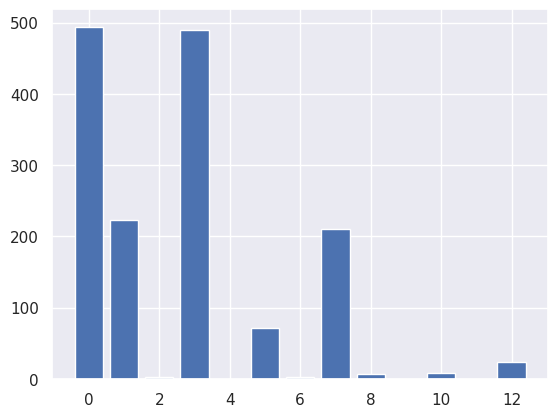

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.bar(*np.unique(test_preds.values.argmax(axis=-1), return_counts=True))

## Submission

In [58]:
submission = pd.read_csv(f"{data_dir}/SampleSubmission.csv")
display(submission.head())

,Field ID,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
0,11,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
submission["Wheat"] = test_preds[0].values
submission["Mustard"] = test_preds[1].values
submission["Lentil"] = test_preds[2].values
submission["No Crop"] = test_preds[3].values
submission["Green pea"] = test_preds[4].values
submission["Sugarcane"] = test_preds[5].values
submission["Garlic"] = test_preds[6].values
submission["Gram"] = test_preds[7].values
submission["Maize"] = test_preds[8].values
submission["Coriander"] = test_preds[9].values
submission["Potato"] = test_preds[10].values
submission["Bersem"] = test_preds[11].values
submission["Rice"] = test_preds[12].values

display(submission.head())

,Field ID,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
0,11,0.254622,0.318820,0.030281,0.057689,0.002891,0.332933,0.000298,0.000094,0.000852,0.000031,0.000212,0.000059,0.001217
1,13,0.621835,0.136817,0.009378,0.210885,0.003181,0.012670,0.000783,0.000689,0.000029,0.000213,0.000307,0.001171,0.002043
2,19,0.305312,0.287499,0.028272,0.071070,0.001609,0.303718,0.000373,0.000178,0.000020,0.001643,0.000108,0.000177,0.000021
3,21,0.053262,0.242624,0.014435,0.538497,0.002883,0.133026,0.001681,0.001499,0.000388,0.000072,0.006968,0.004488,0.000177
4,25,0.194766,0.026935,0.071849,0.703702,0.000100,0.002080,0.000142,0.000277,0.000002,0.000036,0.000004,0.000097,0.000010


In [60]:
submission.to_csv(f"{data_dir}/submission.csv", index = False)